In [10]:
import pandas as pd
import numpy as np
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem.snowball import SnowballStemmer
import sklearn.metrics
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Content-based Filtering

In [14]:
movies_df = pd.read_csv('movies_metadata.csv')
links_small_df = pd.read_csv('links_small.csv')
credits_df = pd.read_csv('credits.csv')
keywords_df = pd.read_csv('keywords.csv')

C:\Users\dcvieira\AppData\Local\Temp\ipykernel_13020\779187633.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies_df = pd.read_csv('movies_metadata.csv')


In [15]:
movies_df = movies_df.drop([19730, 29503, 35587])
keywords_df['id'] = keywords_df['id'].astype('int')
credits_df['id'] = credits_df['id'].astype('int')
movies_df['id'] = movies_df['id'].astype('int')
links_small_df = links_small_df[links_small_df['tmdbId'].notnull()]['tmdbId'].astype('int')


movies_small_df = movies_df[movies_df['id'].isin(links_small_df)]

movies_small_df = movies_small_df.merge(credits_df, on='id')
movies_small_df = movies_small_df.merge(keywords_df, on='id')

# Preenche NaNs na coluna 'genres' com listas vazias, converte strings para listas,
# e extrai os nomes dos gêneros se o valor for uma lista.
movies_small_df['genres'] = movies_small_df['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
movies_small_df['genres'].head()

#movies_small_df['tagline'] = movies_small_df['tagline'].fillna('')
#movies_small_df['description'] = movies_small_df['overview'] + movies_df['tagline']
#movies_small_df['description'] = movies_small_df['description'].fillna('')

movies_small_df['cast'] = movies_small_df['cast'].apply(literal_eval)
#movies_small_df['cast_size'] = movies_small_df['cast'].apply(lambda x: len(x))
movies_small_df['cast'] = movies_small_df['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
movies_small_df['cast'] = movies_small_df['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)
movies_small_df['cast'] = movies_small_df['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

movies_small_df['crew'] = movies_small_df['crew'].apply(literal_eval)
#movies_small_df['crew_size'] = movies_small_df['crew'].apply(lambda x: len(x))


def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

movies_small_df['director'] = movies_small_df['crew'].apply(get_director)

movies_small_df['director'] = movies_small_df['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
movies_small_df['director'] = movies_small_df['director'].apply(lambda x: [x,x, x])

movies_small_df['keywords'] = movies_small_df['keywords'].apply(literal_eval)
movies_small_df['keywords'] = movies_small_df['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

s = movies_small_df.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'keyword'
s = s.value_counts()
s = s[s > 1]

def filter_keywords(x):
    words = []
    for i in x:
        if i in s:
            words.append(i)
    return words

stemmer = SnowballStemmer('english')

movies_small_df['keywords'] = movies_small_df['keywords'].apply(filter_keywords)
movies_small_df['keywords'] = movies_small_df['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
movies_small_df['keywords'] = movies_small_df['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

movies_small_df['soup'] = movies_small_df['keywords'] + movies_small_df['cast'] + movies_small_df['director'] + movies_small_df['genres']
movies_small_df['soup'] = movies_small_df['soup'].apply(lambda x: ' '.join(x))

In [16]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0.0, stop_words='english')
tfidf_matrix = tf.fit_transform(movies_small_df['soup'])

In [17]:
tfiddf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tf.get_feature_names_out())
tfiddf_df.index = movies_small_df['title']
tfiddf_df.head()

,11,11 jessicachastain,11 thomashorn,15thcenturi,15thcenturi ottomanempir,15thcenturi tomhulce,16thcenturi,16thcenturi alpacino,16thcenturi catherinemccormack,16thcenturi conquest,...,моррисчестнат jonathanlipnicki,томву,томву lorenzorichelmy,эрикаэлениак,эрикаэлениак angieeverhart,эрикаэлениак dennishopper,эрикаэлениак joshuabrand,эрикаэлениак penelopespheeris,松隆子,松隆子 masakiokada
title,,,,,,,,,,,,,,,,,,,,,
Toy Story,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Jumanji,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Grumpier Old Men,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Waiting to Exhale,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Father of the Bride Part II,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [19]:
movies_small_df = movies_small_df.reset_index()
titles = movies_small_df['title']
indices = pd.Series(movies_small_df.index, index=movies_small_df['title'])

In [20]:
cosine_similarity_df = pd.DataFrame(cosine_sim, index=titles, columns=titles)
cosine_similarity_df.head()

title,Toy Story,Jumanji,Grumpier Old Men,Waiting to Exhale,Father of the Bride Part II,Heat,Sabrina,Tom and Huck,Sudden Death,GoldenEye,...,Pokémon: Spell of the Unknown,Pokémon: Spell of the Unknown,Pokémon 4Ever: Celebi - Voice of the Forest,Pokémon 4Ever: Celebi - Voice of the Forest,Pokémon 4Ever: Celebi - Voice of the Forest,Pokémon 4Ever: Celebi - Voice of the Forest,Force Majeure,Force Majeure,Force Majeure,Force Majeure
title,,,,,,,,,,,,,,,,,,,,,
Toy Story,1.000000,0.004359,0.001797,0.001704,0.001515,0.000000,0.001766,0.005477,0.00000,0.000000,...,0.019274,0.019274,0.012384,0.012384,0.012384,0.012384,0.001431,0.001431,0.001431,0.001431
Jumanji,0.004359,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010317,0.00407,0.003039,...,0.023514,0.023514,0.028127,0.028127,0.028127,0.028127,0.000000,0.000000,0.000000,0.000000
Grumpier Old Men,0.001797,0.000000,1.000000,0.005475,0.001810,0.000000,0.005676,0.000000,0.00000,0.000000,...,0.014929,0.014929,0.000000,0.000000,0.000000,0.000000,0.001710,0.001710,0.001710,0.001710
Waiting to Exhale,0.001704,0.000000,0.005475,1.000000,0.001717,0.000906,0.005383,0.001544,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007405,0.007405,0.007405,0.007405
Father of the Bride Part II,0.001515,0.000000,0.001810,0.001717,1.000000,0.000000,0.001780,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001442,0.001442,0.001442,0.001442


In [21]:
cosine_similarity_series = cosine_similarity_df.loc['The Dark Knight']
ordered_similarities = cosine_similarity_series.sort_values(ascending=False)
ordered_similarities.head(10)

title
The Dark Knight          1.000000
The Dark Knight Rises    0.407934
Batman Begins            0.377810
The Prestige             0.314610
Inception                0.253601
Following                0.252539
Insomnia                 0.246739
Memento                  0.230004
Interstellar             0.185897
Batman Returns           0.160157
Name: The Dark Knight, dtype: float64

# Colaborative Filtering

In [24]:
movies_df = pd.read_csv('movies_metadata.csv')
user_ratings_df = pd.read_csv('ratings_small.csv')

C:\Users\dcvieira\AppData\Local\Temp\ipykernel_13020\1773618687.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies_df = pd.read_csv('movies_metadata.csv')


In [25]:
user_ratings_df.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [26]:
user_ratings_table = user_ratings_df.pivot(index='userId', columns='movieId', values='rating')
user_ratings_table.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
# Get the average rating for each user
avg_ratings = user_ratings_table.mean(axis=1)

# Center each users ratings around 0
user_ratings_table_centered = user_ratings_table.sub(avg_ratings, axis=0)

# Fill in the missing data with 0s
user_ratings_table_centered = user_ratings_table_centered.fillna(0)
user_ratings_table_centered.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.513158,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,-0.348039,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.09,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
# separamos o usuário (2) que estamos tentando prever a avaliação
target_user = user_ratings_table_centered.loc[[2]]
target_user.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.513158,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
# removemos o filme (1) que estamos tentando prever a avaliação
remove_movie_we_are_predicting = user_ratings_table_centered.drop( 1 , axis =1)
remove_movie_we_are_predicting.head()

movieId,2,3,4,5,6,7,8,9,10,11,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.513158,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,-0.348039,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.09,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
# criação de Data Frame com todos os filmes, mas somente com usuários que avaliaram o filme (1)
users_watched_this_movie = user_ratings_table[1]
df_filled_users_watched_thismovie = user_ratings_table_centered[users_watched_this_movie.notnull()]
users_watched_this_movie.dropna(inplace = True)

In [31]:
df_filled_users_watched_thismovie.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
7,-0.465909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,-0.465909,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.244444,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,1.254717,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,-0.621765,-0.621765,0.000000,0.000000,1.878235,1.378235,0.000000,0.0,0.000000,0.378235,...,0.0,-2.121765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,-0.534279,-0.534279,-0.534279,-0.534279,0.000000,-0.534279,-0.534279,0.0,-0.534279,-0.534279,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
users_watched_this_movie.head()

userId
7     3.0
9     4.0
13    5.0
15    2.0
19    3.0
Name: 1, dtype: float64

In [33]:
from sklearn.neighbors import KNeighborsRegressor
user_knn = KNeighborsRegressor(metric='cosine', n_neighbors=5)
user_knn.fit(df_filled_users_watched_thismovie, users_watched_this_movie)
user_user_pred = user_knn.predict(target_user)
print(user_user_pred)

[4.6]


In [44]:
j=0
l=[]
list_columns = user_ratings_table.columns
for i in user_ratings_table.iloc[1]:
    if not(np.isnan(i)) :
        l.append(list_columns[j])
    j=j+1

print(l)

[np.int64(10), np.int64(17), np.int64(39), np.int64(47), np.int64(50), np.int64(52), np.int64(62), np.int64(110), np.int64(144), np.int64(150), np.int64(153), np.int64(161), np.int64(165), np.int64(168), np.int64(185), np.int64(186), np.int64(208), np.int64(222), np.int64(223), np.int64(225), np.int64(235), np.int64(248), np.int64(253), np.int64(261), np.int64(265), np.int64(266), np.int64(272), np.int64(273), np.int64(292), np.int64(296), np.int64(300), np.int64(314), np.int64(317), np.int64(319), np.int64(339), np.int64(349), np.int64(350), np.int64(356), np.int64(357), np.int64(364), np.int64(367), np.int64(370), np.int64(371), np.int64(372), np.int64(377), np.int64(382), np.int64(405), np.int64(410), np.int64(454), np.int64(457), np.int64(468), np.int64(474), np.int64(480), np.int64(485), np.int64(497), np.int64(500), np.int64(508), np.int64(509), np.int64(515), np.int64(527), np.int64(537), np.int64(539), np.int64(550), np.int64(551), np.int64(552), np.int64(585), np.int64(586), n

In [45]:
original = []
for i in l[0:50]:
    original.append(user_ratings_table.iloc[1][i])
print(original)

[np.float64(4.0), np.float64(5.0), np.float64(5.0), np.float64(4.0), np.float64(4.0), np.float64(3.0), np.float64(3.0), np.float64(4.0), np.float64(3.0), np.float64(5.0), np.float64(4.0), np.float64(3.0), np.float64(3.0), np.float64(3.0), np.float64(3.0), np.float64(3.0), np.float64(3.0), np.float64(5.0), np.float64(1.0), np.float64(3.0), np.float64(3.0), np.float64(3.0), np.float64(4.0), np.float64(4.0), np.float64(5.0), np.float64(5.0), np.float64(3.0), np.float64(4.0), np.float64(3.0), np.float64(4.0), np.float64(3.0), np.float64(4.0), np.float64(2.0), np.float64(1.0), np.float64(3.0), np.float64(4.0), np.float64(4.0), np.float64(3.0), np.float64(3.0), np.float64(3.0), np.float64(3.0), np.float64(2.0), np.float64(3.0), np.float64(3.0), np.float64(3.0), np.float64(3.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(3.0)]


In [46]:
def similarity(metric , list_not_empty , k):
    l = []
    for i in list_not_empty[0:50]:
        target_user = user_ratings_table_centered.iloc[[i]]
        users_watched_this_movie = user_ratings_table[1]
        df_filled_users_watched_thismovie = user_ratings_table_centered[users_watched_this_movie.notnull()]
        users_watched_this_movie.dropna(inplace = True)
        user_knn = KNeighborsRegressor(metric= metric , n_neighbors=k)
        user_knn.fit(df_filled_users_watched_thismovie, users_watched_this_movie)
        user_user_pred = user_knn.predict(target_user)
        l.append(user_user_pred[0])
    return l

In [47]:
best_k= None
best_error = 2
k_results =[]
for i in range(1,12):
    #we will use cosine similarity it gives better results already
    test_cosine = similarity('cosine',l, i)
    evaluation = sklearn.metrics.mean_squared_error(original, test_cosine)
    k_results.append(evaluation)
    print("The evaluation at k = "+ str(i) + " equals to "+ str(evaluation))
    if evaluation < best_error:
        best_k = i
        best_error = evaluation

print("---------------------Final Best result at K => " + str(best_k)+ "-------------------------------")

The evaluation at k = 1 equals to 1.835
The evaluation at k = 2 equals to 1.4175
The evaluation at k = 3 equals to 1.1294444444444445
The evaluation at k = 4 equals to 1.123125
The evaluation at k = 5 equals to 1.0358
The evaluation at k = 6 equals to 1.07625
The evaluation at k = 7 equals to 1.0786734693877549
The evaluation at k = 8 equals to 1.114765625
The evaluation at k = 9 equals to 1.1141975308641976
The evaluation at k = 10 equals to 1.1458999999999997
The evaluation at k = 11 equals to 1.1136776859504132
---------------------Final Best result at K => 5-------------------------------


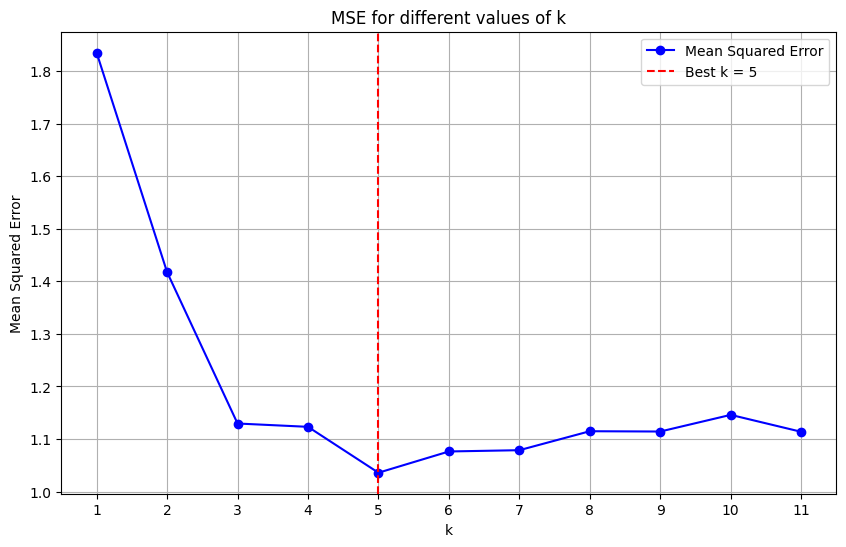

In [48]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 12), k_results, marker='o', linestyle='-', color='b', label='Mean Squared Error')
# Garantindo que o eixo X tenha apenas valores inteiros
plt.xticks(range(1, 12))

plt.axvline(x=best_k, color='r', linestyle='--', label=f'Best k = {best_k}')
plt.title('MSE for different values of k')
plt.xlabel('k')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()

In [49]:
test_cosine = similarity('cosine', l, 5)

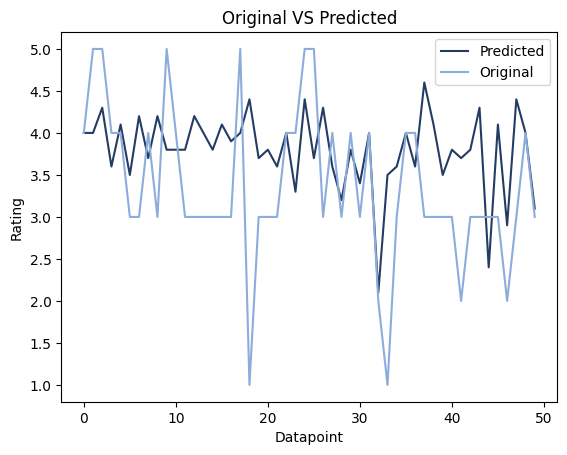

In [50]:
plt.plot(test_cosine, label = "Predicted",color="#243c63")
plt.plot(original, label = "Original", color ='#8cacdc')
plt.legend()
plt.xlabel("Datapoint")
plt.ylabel("Rating")
plt.title('Original VS Predicted')
plt.show()

In [51]:
e_cosine =[sklearn.metrics.mean_squared_error(original, test_cosine), mean_absolute_error(original,test_cosine)]


In [54]:
evaluation_df = pd.DataFrame( {
                "Cosine similarity" : e_cosine,},
                index=['RMSE', 'MAE']
)

evaluation_df

,Cosine similarity
RMSE,1.0358
MAE,0.7940
